In [46]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import h5py  
from astropy.time import Time
import icepyx
from icepyx import icesat2data as ipd
import glob
import os
import sys
import re
import h5py
import pyproj

In [47]:
! cd ..; [ -d pointCollection ] || git clone https://www.github.com/smithB/pointCollection.git
sys.path.append(os.path.join(os.getcwd(), '..'))
import pointCollection as pc

Cloning into 'pointCollection'...
remote: Enumerating objects: 142, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 388 (delta 64), reused 113 (delta 47), pack-reused 246
Receiving objects: 100% (388/388), 58.90 MiB | 52.22 MiB/s, done.
Resolving deltas: 100% (189/189), done.
Checking out files: 100% (57/57), done.


In [48]:
#spatial_extent = np.array([-102, -76, -98, -74.5])
spatial_extent = np.array([-65, -86, -55, -81])
lat=spatial_extent[[1, 3, 3, 1, 1]]
lon=spatial_extent[[2, 2, 0, 0, 2]]
print(lat)
print(lon)
# project the coordinates to Antarctic polar stereographic
xy=np.array(pyproj.Proj(3031)(lon, lat))
# get the bounds of the projected coordinates 
XR=[np.nanmin(xy[0,:]), np.nanmax(xy[0,:])]
YR=[np.nanmin(xy[1,:]), np.nanmax(xy[1,:])]
MOA=pc.grid.data().from_geotif(os.path.join(data_root, 'MOA','/srv/tutorial-data/land_ice_applications/moa_2009_1km.tif'), bounds=[XR, YR])


[-86 -81 -81 -86 -86]
[-55 -55 -65 -65 -55]


AttributeError: 'NoneType' object has no attribute 'GetGeoTransform'

In [35]:
data_root='/srv/shared/surface_velocity/'

In [36]:
def atl06_to_dict(filename, beam, field_dict=None, index=None, epsg=None):
    """
        Read selected datasets from an ATL06 file

        Input arguments:
            filename: ATl06 file to read
            beam: a string specifying which beam is to be read (ex: gt1l, gt1r, gt2l, etc)
            field_dict: A dictinary describing the fields to be read
                    keys give the group names to be read, 
                    entries are lists of datasets within the groups
            index: which entries in each field to read
            epsg: an EPSG code specifying a projection (see www.epsg.org).  Good choices are:
                for Greenland, 3413 (polar stereographic projection, with Greenland along the Y axis)
                for Antarctica, 3031 (polar stereographic projection, centered on the Pouth Pole)
        Output argument:
            D6: dictionary containing ATL06 data.  Each dataset in 
                dataset_dict has its own entry in D6.  Each dataset 
                in D6 contains a numpy array containing the 
                data
    """
    if field_dict is None:
        field_dict={None:['latitude','longitude','h_li', 'atl06_quality_summary'],\
                    'ground_track':['x_atc','y_atc'],\
                    'fit_statistics':['dh_fit_dx', 'dh_fit_dy']}
    D={}
    file_re=re.compile('ATL06_(?P<date>\d+)_(?P<rgt>\d\d\d\d)(?P<cycle>\d\d)(?P<region>\d\d)_(?P<release>\d\d\d)_(?P<version>\d\d).h5')
    with h5py.File(filename,'r') as h5f:
        for key in field_dict:
            for ds in field_dict[key]:
                if key is not None:
                    ds_name=beam+'/land_ice_segments/'+key+'/'+ds
                else:
                    ds_name=beam+'/land_ice_segments/'+ds
                if index is not None:
                    D[ds]=np.array(h5f[ds_name][index])
                else:
                    D[ds]=np.array(h5f[ds_name])
                if '_FillValue' in h5f[ds_name].attrs:
                    bad_vals=D[ds]==h5f[ds_name].attrs['_FillValue']
                    D[ds]=D[ds].astype(float)
                    D[ds][bad_vals]=np.NaN
    if epsg is not None:
        xy=np.array(pyproj.proj.Proj(epsg)(D['longitude'], D['latitude']))
        D['x']=xy[0,:].reshape(D['latitude'].shape)
        D['y']=xy[1,:].reshape(D['latitude'].shape)
    temp=file_re.search(filename)
    D['rgt']=int(temp['rgt'])
    D['cycle']=int(temp['cycle'])
    D['beam']=beam
    return D

In [37]:
# find all the files in the directory:
#ATL06_files=glob.glob(os.path.join(data_root, 'PIG_ATL06', '*.h5'))
data_root='/srv/shared/surface_velocity/'
ATL06_files=glob.glob(os.path.join(data_root, 'FIS_ATL06_small', '*.h5'))
D_dict={}
error_count=0
for file in ATL06_files:
    try:
        D_dict[file]=atl06_to_dict(file, '/gt2l', index=slice(0, -1, 25), epsg=3031)
    except KeyError as e:
        print(f'file {file} encountered error {e}')
        error_count += 1
print(f"read {len(D_dict)} data files of which {error_count} gave errors")

NameError: name 'pyproj' is not defined

NameError: name 'MOA' is not defined

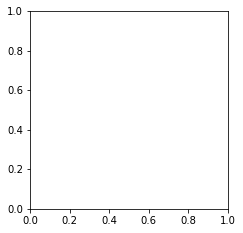

In [38]:
plt.figure(figsize=[8,8])
hax0=plt.gcf().add_subplot(211, aspect='equal')
MOA.show(ax=hax0, cmap='gray', clim=[14000, 17000]);
hax1=plt.gcf().add_subplot(212, aspect='equal', sharex=hax0, sharey=hax0)
MOA.show(ax=hax1, cmap='gray', clim=[14000, 17000]);
for fname, Di in D_dict.items():
    cycle=Di['cycle']
    if cycle <= 2:
        ax=hax0
    else:
        ax=hax1
    #print(fname)
    #print(f'\t{rgt}, {cycle}, {region}')
    ax.plot(Di['x'], Di['y'])
    if True:
        try:
            if cycle  < 3:
                ax.text(Di['x'][0], Di['y'][0], f"rgt={Di['rgt']}, cyc={cycle}", clip_on=True)
            elif cycle==3:
                ax.text(Di['x'][0], Di['y'][0], f"rgt={Di['rgt']}, cyc={cycle}+", clip_on=True)
        except IndexError:
            pass
hax0.set_title('cycles 1 and 2');
hax1.set_title('cycle 3+');

In [ ]:
map_fig=plt.figure()
map_ax=map_fig.add_subplot(111)
MOA.show(ax=map_ax, cmap='gray', clim=[14000, 17000])
for fname, Di in D_dict.items():
    # select elevations with good quality_summary
    good=Di['atl06_quality_summary']==0
    ms=map_ax.scatter( Di['x'][good], Di['y'][good],  2, c=Di['h_li'][good], \
                  vmin=0, vmax=1000, label=fname)
map_ax._aspect='equal'
plt.colorbar(ms, label='elevation');

In [29]:
D_2l={}
D_2r={}

# specify the rgt here:
rgt="1092"
# iterate over the repeat cycles
for cycle in ['03','04','05','06','07']:
    for filename in glob.glob(os.path.join(data_root, 'FIS_ATL06_small', f'*ATL06_*_{rgt}{cycle}*_003*.h5')):
        try:
            # read the left-beam data
            D_2l[filename]=atl06_to_dict(filename,'/gt2l', index=None, epsg=3031)
            # read the right-beam data
            D_2r[filename]=atl06_to_dict(filename,'/gt2r', index=None, epsg=3031)
            # plot the locations in the previous plot
            map_ax.plot(D_2r[filename]['x'], D_2r[filename]['y'],'k');  
            map_ax.plot(D_2l[filename]['x'], D_2l[filename]['y'],'k');
        except Exception as e:
            print(f'filename={filename}, exception={e}')

filename=/srv/shared/surface_velocity/FIS_ATL06_small/processed_ATL06_20190608191727_10920311_003_01.h5, exception=name 'atl06_to_dict' is not defined
filename=/srv/shared/surface_velocity/FIS_ATL06_small/processed_ATL06_20190907145716_10920411_003_01.h5, exception=name 'atl06_to_dict' is not defined
filename=/srv/shared/surface_velocity/FIS_ATL06_small/processed_ATL06_20191207103705_10920511_003_01.h5, exception=name 'atl06_to_dict' is not defined


No handles with labels found to put in legend.


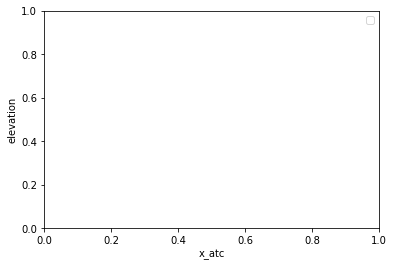

In [30]:
plt.figure();
for filename, Di in D_2l.items():
    #Plot only points that have ATL06_quality_summary==0 (good points)
    hl=plot_segs(Di, ind=Di['atl06_quality_summary']==0, label=f"cycle={Di['cycle']}")
    #hl=plt.plot(Di['x_atc'][Di['atl06_quality_summary']==0], Di['h_li'][Di['atl06_quality_summary']==0], '.', label=f"cycle={Di['cycle']}")
    
plt.legend()
plt.xlabel('x_atc')
plt.ylabel('elevation');